<a href="https://colab.research.google.com/github/maielhadad99/Russian-handwritten-letters/blob/main/Russian_handwritten_letters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [75]:
df1=pd.read_csv("/content/Input/letters.csv")
df1.head()
files1=df1['file']
letters1=df1["letter"]
backgrounds1=df1['background']

In [76]:
df2=pd.read_csv("/content/Input/letters2.csv")
files2=df2['file']
letters2=df2["letter"]
backgrounds2=df2['background']

In [77]:
df3=pd.read_csv("/content/Input/letters3.csv")
files3=df3['file']
letters3=df3["letter"]
backgrounds3=df3['background']

In [78]:
import h5py
f = h5py.File("/content/Input/LetterColorImages_123.h5",'r')
keys = list(f.keys())
keys

['backgrounds', 'images', 'labels']

In [79]:
backgrounds = np.array(f[keys[0]])
tensors = images = np.array(f[keys[1]])
targets = np.array(f[keys[2]])
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)
print ('Background shape:', backgrounds.shape)

Tensor shape: (14190, 32, 32, 3)
Target shape (14190,)
Background shape: (14190,)


In [80]:
letters = pd.concat((df1,df2),axis= 0,ignore_index=True)
letters = pd.concat((letters,df3),axis = 0 , ignore_index=True)
letters.head()

,letter,label,file,background
0,а,1,01_01.png,0
1,а,1,01_02.png,0
2,а,1,01_03.png,0
3,а,1,01_04.png,0
4,а,1,01_05.png,0


In [81]:
len(letters)

14190

In [82]:
tensors = tensors.astype('float32')/255

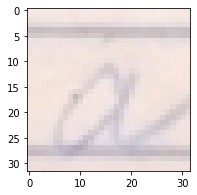

In [83]:
import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

# Read and display a tensor using Matplotlib
plt.figure(figsize=(3,3))
plt.imshow(tensors[10]);

In [86]:
print(set(targets))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}


In [92]:
!pip install utils

In [94]:
from tensorflow.keras.utils import to_categorical

# One-hot encoding the targets, started from the zero label
cat_targets = to_categorical(np.array(targets-1), 33)
cat_targets.shape

(14190, 33)

In [95]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_test, y_train, y_test = train_test_split(tensors, cat_targets,test_size = 0.2,random_state = 1)
                                                     
                                                    
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

# Print the shape
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((11352, 32, 32, 3),
 (11352, 33),
 (1419, 32, 32, 3),
 (1419, 33),
 (1419, 32, 32, 3),
 (1419, 33))

In [99]:
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import top_k_categorical_accuracy, categorical_accuracy
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

model = Sequential()

# Define a model architecture    
model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
model.add(LeakyReLU(alpha=0.02))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(192, (5, 5)))
model.add(LeakyReLU(alpha=0.02))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(GlobalMaxPooling2D())

model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.02))
model.add(Dropout(0.5)) 

model.add(Dense(33))
model.add(Activation('softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=[categorical_accuracy, top_3_categorical_accuracy])

In [100]:
checkpointer = ModelCheckpoint(filepath='weights.best.model.hdf5', verbose=2, save_best_only=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, factor=0.75)
# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=512, verbose=2,validation_data=(x_valid, y_valid),callbacks=[checkpointer, lr_reduction])

Epoch 1/50

Epoch 00001: val_loss improved from inf to 3.48263, saving model to weights.best.model.hdf5
23/23 - 41s - loss: 3.4920 - categorical_accuracy: 0.0324 - top_3_categorical_accuracy: 0.0969 - val_loss: 3.4826 - val_categorical_accuracy: 0.0240 - val_top_3_categorical_accuracy: 0.0951 - lr: 0.0010 - 41s/epoch - 2s/step
Epoch 2/50

Epoch 00002: val_loss improved from 3.48263 to 3.44543, saving model to weights.best.model.hdf5
23/23 - 39s - loss: 3.4628 - categorical_accuracy: 0.0425 - top_3_categorical_accuracy: 0.1195 - val_loss: 3.4454 - val_categorical_accuracy: 0.0557 - val_top_3_categorical_accuracy: 0.1656 - lr: 0.0010 - 39s/epoch - 2s/step
Epoch 3/50

Epoch 00003: val_loss improved from 3.44543 to 3.34845, saving model to weights.best.model.hdf5
23/23 - 39s - loss: 3.3959 - categorical_accuracy: 0.0638 - top_3_categorical_accuracy: 0.1649 - val_loss: 3.3485 - val_categorical_accuracy: 0.0860 - val_top_3_categorical_accuracy: 0.2276 - lr: 0.0010 - 39s/epoch - 2s/step
Epoch

In [ ]:
pred = (model.predict(x_test) > 0.5).astype("int32")
pred